In [4]:
pip show tensorboard-dataservers

Note: you may need to restart the kernel to use updated packages.


In [38]:
!pip install --upgrade matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install zipp==0.5

Defaulting to user installation because normal site-packages is not writeable
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
importlib-resources 5.12.0 requires zipp>=3.1.0; python_version < "3.10", but you have zipp 0.5.0 which is incompatible.
jupyter-client 8.0.2 requires importlib-metadata>=4.8.3; python_version < "3.10", but you have importlib-metadata 4.4.0 which is incompatible.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import tensorflow as tf
import keras
import sklearn
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from platform import  python_version
from glob import glob
from keras import backend as K
from tqdm import tqdm
from PIL import Image

#!pip install patchify
from patchify import patchify

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
import shutil
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import warnings

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

%config Completer.use_jedi = False

sm.set_framework('tf.keras')
sm.framework()

2023-04-08 20:47:01.118627: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 20:47:03.139187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 20:47:03.143020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 20:47:15.353207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Segmentation Models: using `tf.keras` framework.


'tf.keras'

In [6]:
base_dir = 'data/image'
print(os.listdir(base_dir))
print("Keras version : " + keras.__version__)
print("Tensorflow version : " + tf.__version__)
print("Python version : " + python_version())
print("Sklearn version : " + sklearn.__version__)
print("CV2 version : " + cv2.__version__)
print("Pandas version : " + pd.__version__)

['class_dict.csv', '.ipynb_checkpoints', 'train', 'test', 'valid', 'metadata.csv']
Keras version : 2.12.0
Tensorflow version : 2.12.0
Python version : 3.9.13
Sklearn version : 0.24.2
CV2 version : 4.7.0
Pandas version : 1.4.4


In [7]:
filenames = pd.read_csv(os.path.join(base_dir, 'metadata.csv'))
filenames

,image_id,split,sat_image_path,mask_path
0,924236,train,train/924236_sat.jpg,train/924236_mask.png
1,941237,train,train/941237_sat.jpg,train/941237_mask.png
2,942307,train,train/942307_sat.jpg,train/942307_mask.png
3,942594,train,train/942594_sat.jpg,train/942594_mask.png
4,942986,train,train/942986_sat.jpg,train/942986_mask.png
5,943463,train,train/943463_sat.jpg,train/943463_mask.png
6,943943,train,train/943943_sat.jpg,train/943943_mask.png
7,946386,train,train/946386_sat.jpg,train/946386_mask.png
8,946408,train,train/946408_sat.jpg,train/946408_mask.png
9,946475,train,train/946475_sat.jpg,train/946475_mask.png


In [8]:
print(filenames['split'].value_counts())

train    15
valid    13
test     11
Name: split, dtype: int64


In [9]:
train_df = filenames[filenames['split']=='train']
train_df['sat_image_path'] = train_df['sat_image_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))
train_df['mask_path'] = train_df['mask_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))
train_df

/home/u190843/tmp/ipykernel_1164978/3190977296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sat_image_path'] = train_df['sat_image_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))
/home/u190843/tmp/ipykernel_1164978/3190977296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['mask_path'] = train_df['mask_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))


,image_id,split,sat_image_path,mask_path
0,924236,train,data/image/train/924236_sat.jpg,data/image/train/924236_mask.png
1,941237,train,data/image/train/941237_sat.jpg,data/image/train/941237_mask.png
2,942307,train,data/image/train/942307_sat.jpg,data/image/train/942307_mask.png
3,942594,train,data/image/train/942594_sat.jpg,data/image/train/942594_mask.png
4,942986,train,data/image/train/942986_sat.jpg,data/image/train/942986_mask.png
5,943463,train,data/image/train/943463_sat.jpg,data/image/train/943463_mask.png
6,943943,train,data/image/train/943943_sat.jpg,data/image/train/943943_mask.png
7,946386,train,data/image/train/946386_sat.jpg,data/image/train/946386_mask.png
8,946408,train,data/image/train/946408_sat.jpg,data/image/train/946408_mask.png
9,946475,train,data/image/train/946475_sat.jpg,data/image/train/946475_mask.png


Premature end of JPEG file


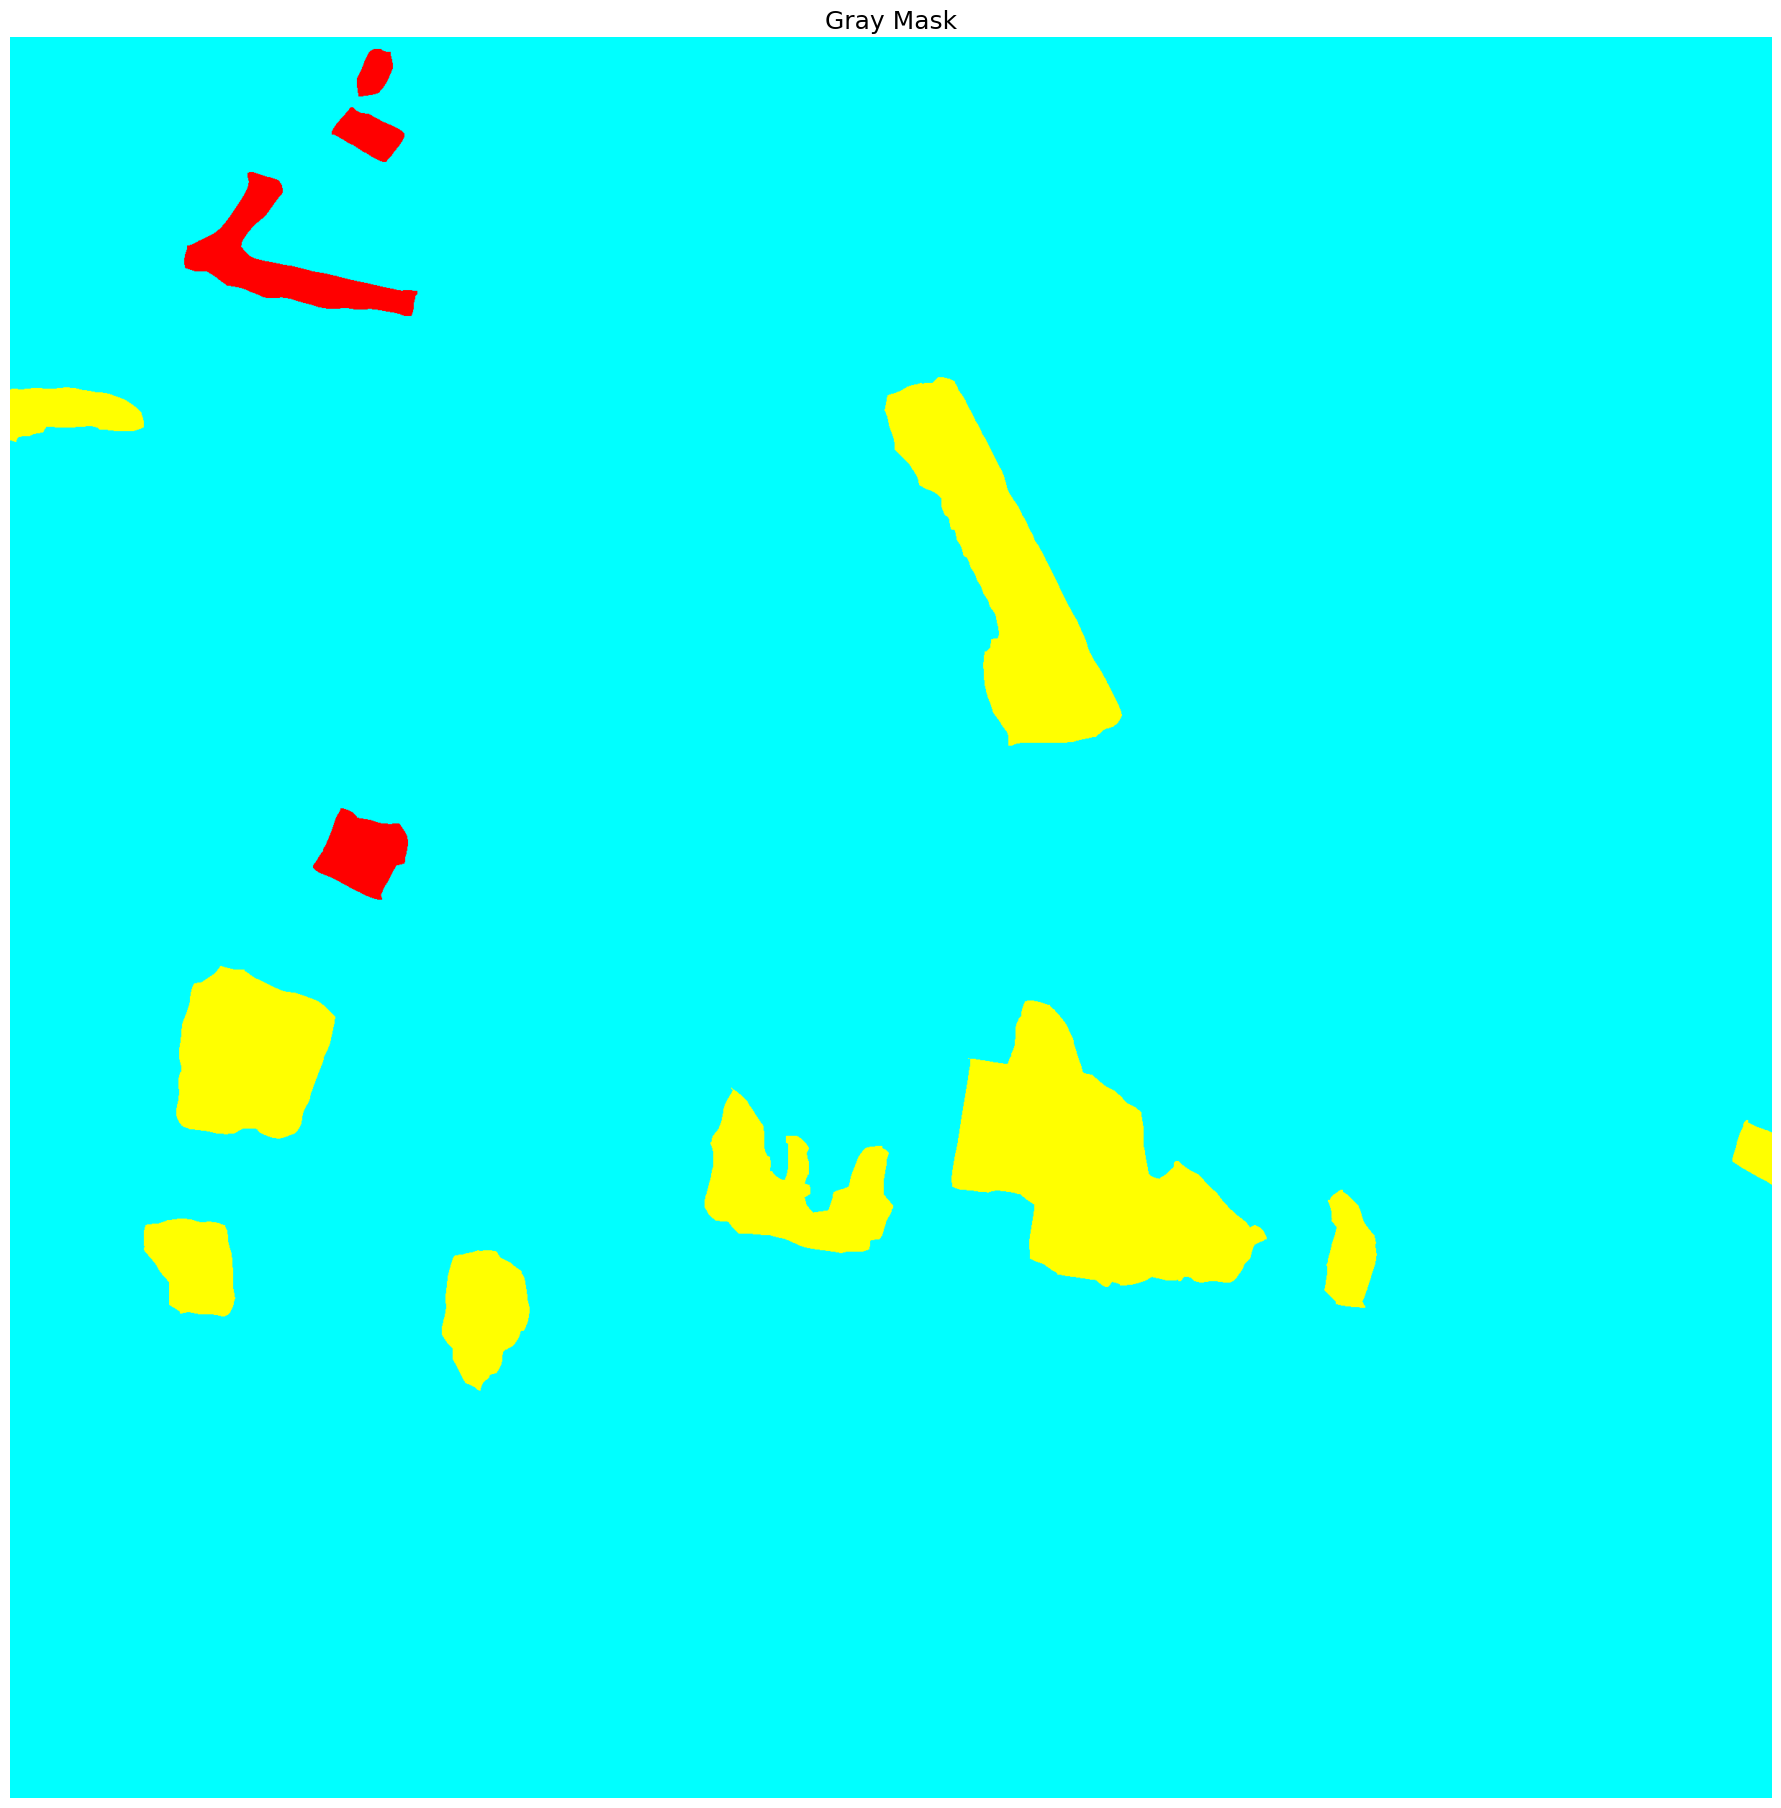

In [10]:
i = np.random.randint(0, len(train_df))
img = cv2.imread(train_df['sat_image_path'].iloc[2])
mask = cv2.imread(train_df['mask_path'].iloc[2])
plt.figure(figsize=(50,50))

plt.subplot(122)
plt.axis('off')
plt.title('Landscape',fontsize=18)
plt.imshow(img)

plt.subplot(122)
plt.axis('off')
plt.title('Gray Mask',fontsize=18 )
plt.imshow(mask)

In [11]:
class_dict = pd.read_csv(os.path.join(base_dir, 'class_dict.csv'))
num_class = len(class_dict)
print(f'Number of classes {num_class}')
class_dict

Number of classes 7


,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [12]:
if os.path.exists('masks256') :
    shutil.rmtree('masks256')
if os.path.exists('images256') :    
    shutil.rmtree('images256')
    
os.mkdir('images256')
os.mkdir('masks256')
patch_size =256


def patches(train_df):
    num_of_saved_files = 0
    for img_path, mask_path in tqdm(train_df[['sat_image_path','mask_path']].to_numpy()):
        image = cv2.imread(img_path, 1)
        mask = cv2.imread(mask_path)
        assert image.shape == mask.shape
        SIZE_X = (image.shape[1]//patch_size)*patch_size 
        SIZE_Y = (image.shape[0]//patch_size)*patch_size
        
        image = Image.fromarray(image)
        image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        image = np.array(image)             

        patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
        patches_mask = patchify(mask, (256, 256, 3), step=256) 
        
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = single_patch_mask[0]
                
                val, counts = np.unique(single_patch_mask, return_counts=True)
                max_counts = np.max(counts)/counts.sum()
                if max_counts < 0.95:
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]
             
                    cv2.imwrite(f'images256/{num_of_saved_files}.tif', single_patch_img)
                    cv2.imwrite(f'masks256/{num_of_saved_files}.tif', single_patch_mask) 
                    num_of_saved_files += 1

In [13]:
patches(train_df)

100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


In [14]:
colors = []
for (r,g,b) in class_dict[['r', 'g', 'b']].to_numpy():
    colors.append([r,g,b])
map_color = {x:v for x,v in zip(range(num_class),colors)}
colors

map_color

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [15]:
num_classes =7
def rgb_to_onehot(rgb_arr):
    color_dict= map_color
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls_ in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def preprocess_data_rgb_to_onehot(img, mask, num_class=7):
    masks = np.zeros((mask.shape[0], 256, 256,7))
    for i ,m in enumerate(mask):
        masks[i] =rgb_to_onehot(m)      
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    return (img,masks)

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def preprocess_data_rgb_to_onehot(img, mask, num_class=7):
    masks = np.zeros((mask.shape[0], 256, 256,7))
    for i ,m in enumerate(mask):
        masks[i] =rgb_to_onehot(m)      
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    return (img,masks)

In [18]:
def onehot_to_rgb(onehot, color_dict= map_color):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [19]:
def onehot_to_rgb(onehot, color_dict= map_color):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [20]:
#!pip install --upgrade tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 32
patched_dir = 'data'

def data_generator(num_class=7):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args )
    
    validation_split= 0.1

    df_len = len(glob(os.path.join(patched_dir,'images256/*.tif')))
    subset = np.empty(df_len, dtype=object)
    subset[:int((1-validation_split)*df_len)] = 'train'
    subset[int((1-validation_split)*df_len):] = 'valid'
    np.random.shuffle(subset)
    df_filenames = pd.DataFrame(np.vstack((np.sort(np.array((glob(os.path.join(patched_dir,'images256/*.tif')),glob(os.path.join(patched_dir,'masks256/*.tif'))))), subset)).T, columns = ['img', 'masks','subset'])    
    df_train = df_filenames[df_filenames.subset  == 'train']
    df_valid = df_filenames[df_filenames.subset  == 'valid']

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    

    mask_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None,
        validate_filenames=False)
   

    image_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None,
        validate_filenames=False) 
     
    train_generator= zip(image_train_generator,mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return(train_generator,valid_generator)
   
def transform_generator(gen):
    for (img, mask) in gen:
        before = (img.shape,mask.shape)
        img, mask = preprocess_data_rgb_to_onehot(img, mask)
        yield (img, mask)
        
def train_valid_gen(num_class=7):
    train_gen,valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return (train_gen,valid_gen)

    print(train_gen)

In [21]:
t, v = train_valid_gen()

Found 1059 validated image filenames.
Found 1059 validated image filenames.
Found 118 non-validated image filenames.
Found 118 non-validated image filenames.


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 32
patched_dir = 'data'
def data_generator(num_class=7):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args )
    
    validation_split= 0.1

    df_len = len(glob(os.path.join(patched_dir,'images256/*.tif')))
    subset = np.empty(df_len, dtype=object)
    subset[:int((1-validation_split)*df_len)] = 'train'
    subset[int((1-validation_split)*df_len):] = 'valid'
    np.random.shuffle(subset)
    df_filenames = pd.DataFrame(np.vstack((np.sort(np.array((glob(os.path.join(patched_dir,'images256/*.tif')),glob(os.path.join(patched_dir,'masks256/*.tif'))))), subset)).T, columns = ['img', 'masks','subset'])    
    df_train = df_filenames[df_filenames.subset  == 'train']
    df_valid = df_filenames[df_filenames.subset  == 'valid']

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    

    mask_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None,
        validate_filenames=False)
   

    image_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None,
        validate_filenames=False) 
     
    train_generator = zip(image_train_generator, mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return train_generator, valid_generator
   
def train_valid_gen(num_class=7,shuffle=True):
    train_gen, valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return train_gen, valid_gen

train_gen, valid_gen = train_valid_gen()
print(train_gen)


Found 1059 validated image filenames.
Found 1059 validated image filenames.
Found 118 non-validated image filenames.
Found 118 non-validated image filenames.
<generator object transform_generator at 0x7f9d0c9144a0>


In [23]:
t, v = train_valid_gen()

Found 1059 validated image filenames.
Found 1059 validated image filenames.
Found 118 non-validated image filenames.
Found 118 non-validated image filenames.


In [24]:
%%time
x, y=next(t)

CPU times: user 6 s, sys: 135 ms, total: 6.13 s
Wall time: 6.42 s


In [25]:
def one_hot_encode(label):
    label_values = colors
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype('float')

    return semantic_map

In [26]:
def preprocess_data(imgs, masks):
    return (imgs,one_hot_encode(masks))

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 32

patched_dir = 'data'

def data_generator(num_class=7):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args, rescale=1.0/255.0)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)


    validation_split= 0.2

    df_len = len(glob(os.path.join(patched_dir,'images256/*.tif')))
    subset = np.empty(df_len, dtype=object)
    subset[:int((1-validation_split)*df_len)] = 'train'
    subset[int((1-validation_split)*df_len):] = 'valid'
    np.random.shuffle(subset)
    df_filenames = pd.DataFrame(np.vstack((np.sort(np.array((glob(os.path.join(patched_dir,'images256/*.tif')),glob(os.path.join(patched_dir,'masks256/*.tif'))))), subset)).T, columns = ['img', 'masks','subset'])
    df_train = df_filenames[df_filenames.subset  == 'train']
    df_valid = df_filenames[df_filenames.subset  == 'valid']

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    

    mask_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
   

    image_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None) 
     
    train_generator= zip(image_train_generator,mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return(train_generator,valid_generator)
   
def transform_generator(gen):
    for (img, mask) in gen:
        img, mask = preprocess_data(img, mask)
        yield (img, mask)
        
def train_valid_gen(num_class=7,shuffle=True):
    train_gen,valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return (train_gen,valid_gen)
    train_gen, valid_gen = train_valid_gen()
    print(train_gen)

In [28]:
t, v = train_valid_gen()

Found 941 validated image filenames.
Found 941 validated image filenames.
Found 236 validated image filenames.
Found 236 validated image filenames.


[ WARN:0@178.488] global loadsave.cpp:244 findDecoder imread_('/image/masks256/1.tif'): can't open/read file: check file path/integrity
[ WARN:0@179.824] global loadsave.cpp:244 findDecoder imread_('/image/masks256/1.tif'): can't open/read file: check file path/integrity


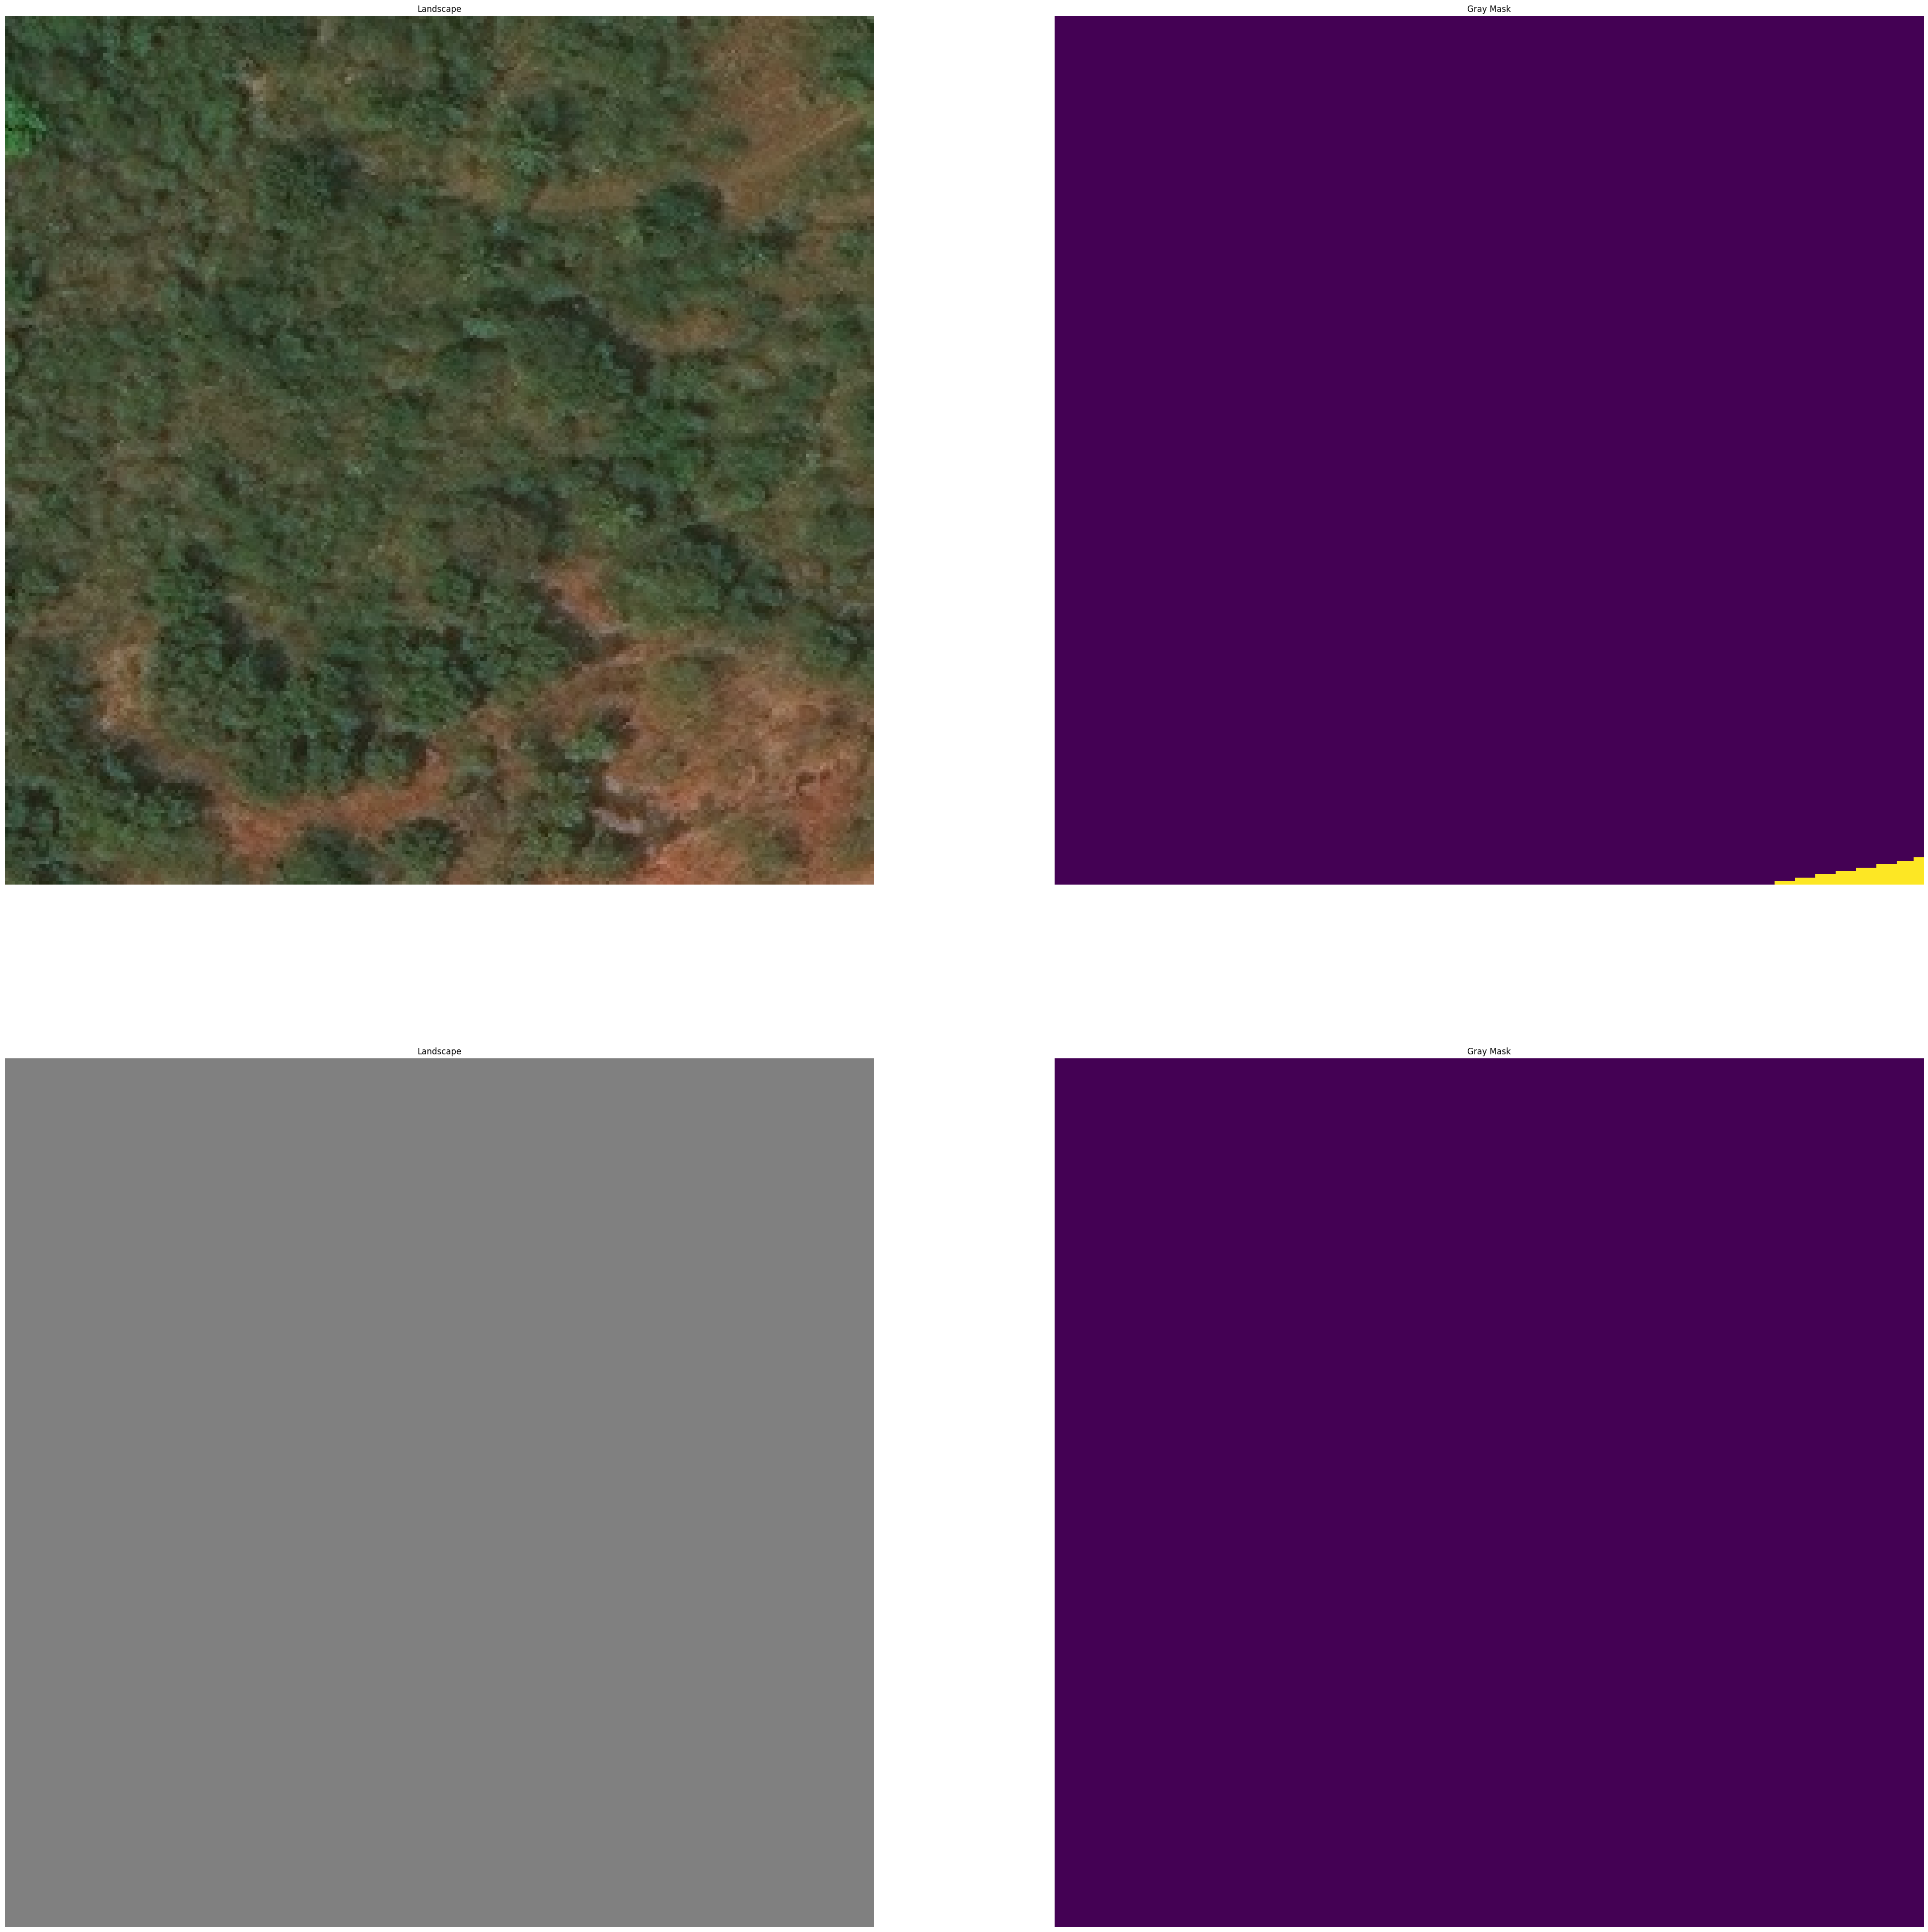

In [29]:
def check_gens(train_gen, valid_gen):
    x, y = next(train_gen)
    i =8
    plt.figure(figsize = (50,50))
    plt.subplot(221)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(222)
    plt.axis('off')
    plt.title('Gray Mask')
    mask =  cv2.imread('/image/masks256/1.tif')
    plt.imshow(np.argmax((y)[i],axis=2)*64)


    x, y = next(valid_gen)
    plt.subplot(223)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(224)
    plt.axis('off')
    plt.title('Gray Mask')
    mask =  cv2.imread('/image/masks256/1.tif')
    plt.imshow(np.argmax((y)[i],axis=2)*64)
check_gens(t,v)

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

def callback(name):
    checkpoint = ModelCheckpoint("{}.h5".format(name), monitor='val_iou_score', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
    reduce = ReduceLROnPlateau(monitor='val_iou_score',
                                   patience=2, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

    early = EarlyStopping(monitor="val_iou_score", 
                      mode="min", 
                      patience=2)
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(name))
    
    callbacks = [checkpoint, early, reduce,tensorboard]

    return callbacks



In [31]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_class, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [32]:
model = unet()
from tensorflow.keras.metrics import MeanIoU
model.compile(optimizer = Adam(learning_rate = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [37]:
def u_net_modell(backbones):
    print("hello")
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']
    histories = {}
    
    for backbone in backbones:
        callbacks = callback(backbone)
        print("t")
        
        #train_gen_length = 0
    #for _ in train_gen:
     #   train_gen_length += 1
    #for _ in valid_gen:
     #   valid_gen_length += 1    

        model = sm.Unet(backbone, encoder_weights='imagenet', 
                input_shape=(256,256,3),
                classes=7, activation='softmax')
        model.compile(optimizer=Adam(lr=0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
        
        train_gen, valid_gen = train_valid_gen(7, shuffle=True) # shuffle the data between epochs
        print('Model: {}'.format(backbone))
        
        history = model.fit_generator(train_gen,
                epochs=1, validation_data=valid_gen, callbacks=callbacks)
        
        model.save('{}.h5'.format(backbone))
        histories[backbone] = history
    
    return histories


In [ ]:
def u_net_model(backbones):
    print("hello")
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    histories = {}
    
    for backbone in backbones:
        callbacks = callback(backbone)
        print("t")
        
        model = sm.Unet(backbone, encoder_weights='imagenet', 
                input_shape=(128, 128, 3),
                classes=7, activation='softmax')
        model.compile(optimizer=Adam(lr=0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
        
        train_gen, valid_gen = train_valid_gen(7, shuffle=True) # reduce batch size
        print('Model: {}'.format(backbone))
        
        history = model.fit_generator(train_gen,
                epochs=1, validation_data=valid_gen, callbacks=callbacks)
        
        model.save('{}.h5'.format(backbone))
        histories[backbone] = history
    
    return histories

backbones = ['resnet34', 'inceptionv3'] # reduce the number of backbones
histories = u_net_model(backbones)


hello


t


Found 941 validated image filenames.
Found 941 validated image filenames.
Found 236 validated image filenames.
Found 236 validated image filenames.
Model: resnet34


/home/u190843/tmp/ipykernel_1164978/3531008990.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,
2023-04-08 16:30:11.933949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   1190/Unknown - 10841s 9s/step - loss: 0.5872 - iou_score: 0.5854 - f1-score: 0.6730

In [ ]:
backbones = ['resnet34', 'inceptionv3', 'vgg16']
histories = u_net_model(backbones)

In [ ]:
def predict_image(model, img):
    w,h = img.shape[:2]
    w = w // 256 +1
    h = h // 256 +1
    padding_shape = (w*256,h*256 ,3)
    padded_img= np.zeros(padding_shape)
    mask_shape = (w*256,h*256,7)

    padded_img[0:img.shape[0], 0:img.shape[1], :] = img
    padded_img = padded_img/255
    mask_padded = np.zeros(mask_shape)

    for i in range(0,mask_shape[0], 256):
        for j in range(0, mask_shape[1], 256):
            patch = padded_img[i:i+256,j:j+256,:]
            predicted  = model.predict(np.expand_dims(patch,axis=0))
            mask_padded[i:i+256,j:j+256,:] =predicted 
    return mask_padded[0:img.shape[0], 0:img.shape[1], :]

In [ ]:
models_path = ['/image/resnet34.h5','/image/inceptionv3.h5', '/image/vgg16.h5']

In [ ]:
img = cv2.imread('image/train/102122_mask.png')

In [ ]:
predicted_masks = predict(img, models_path)

In [ ]:
def plot(predicted_masks):
    plt.figure(figsize=(50,50))
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

    plt.subplot(151)
    plt.title('Original Image' ,fontsize=18)
    plt.axis('off')
    plt.imshow(img)

    plt.subplot(152)
    plt.title('Mask {}'.format(backbones[0]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[0]))

    plt.subplot(153)
    plt.title('Mask {}'.format(backbones[1]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[1]))

    plt.subplot(154)
    plt.title('Mask {}'.format(backbones[2]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[2]))
    plt.savefig('models_masks.jpeg',dpi = 100)
plot(predicted_masks)

In [ ]:
img = cv2.imread('image/valid/251219_sat.jpg')

In [ ]:
predicted_masks = predict(img, models_path)

In [ ]:
plot(predicted_masks)